In [1]:
cd /home/makinen/repositories/fishnets

/home/makinen/repositories/fishnets


In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
from tqdm import trange
from scipy import stats
tfk = tf.keras

from fishnets import *

/softs/python/py3mods/tensorflow/2.10.1/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


## create simple lighthouse example where deepsets might fail

Let's do the lighthouse problem, which will get us back to the Cauchy distribution

In [3]:
# data sizes
n_sims = 10000
n_data = 500

n_theta = 2


# fiducial parameters
theta_fid = tf.constant([1.,2.0], dtype=tf.float32)
theta_fid_ = theta_fid.numpy()

# prior mean and covariance
priorCinv = tf.convert_to_tensor(np.eye(2), dtype=tf.float32)
priormu = tf.constant([0.,0.], dtype=tf.float32)

# get positions - THESE ARE THE THETA WE WANT
alpha = np.random.uniform(low=-5, high=5, size=(n_sims,))
beta = np.random.uniform(low=0, high=5, size=(n_sims,))

# get random angles at which flashes are generated from lighthouse
thetaD = np.random.uniform(-np.pi/2., np.pi/2., size=(n_sims, n_data))

# get the random distances (the data) at which the flashes are measured
x_k = (beta[..., np.newaxis] * np.tan(thetaD)) + alpha[..., np.newaxis]

sigma_noise = np.random.uniform(low=0.1, high=0.5, size=(n_sims, n_data))

# now stack all of the data and add some noise
data = np.random.normal(loc=x_k, scale=sigma_noise)[..., np.newaxis]

# make data neural-network friendly
datamax = 5.0
data /= datamax

# stack up parameters
theta = np.zeros((n_sims, 2))
theta[:, 0] = alpha
theta[:, 1] = beta

data.shape, theta.shape

((10000, 500, 1), (10000, 2))

In [4]:
# fishnet class (seperate network models for both score and fisher)
class FishnetDeepset(tf.Module):
    
    def __init__(self, n_parameters=2, n_inputs=3, n_hidden_score=[128, 128], activation_score=[tf.nn.leaky_relu, tf.nn.leaky_relu], 
        n_hidden_globals=[128,128], activation_globals=[tf.nn.leaky_relu, tf.nn.leaky_relu], n_hidden_fisher=[128, 128], 
        activation_fisher=[tf.nn.leaky_relu, tf.nn.leaky_relu], priormu=None, priorCinv=None, theta_fid=None, 
        optimizer=tf.keras.optimizers.Adam(lr=1e-4), maxcall=1e5, restore=False, restore_filename=None):
        
        # restore?
        if restore:
            print("loading model")
            self.n_parameters, self.n_inputs, self.maxcall, self.n_hidden_score, self.n_hidden_fisher, self.activation_score, self.activation_fisher, self.priormu, self.priorCinv, self.theta_fid, loaded_trainable_variables = pickle.load(open(restore_filename, 'rb'))
            self.optimizer = optimizer
        else:
            # parameters
            self.n_parameters = n_parameters
            self.n_inputs = n_inputs
            self.maxcall = int(maxcall)

            # architecture parameters
            self.n_hidden_score = n_hidden_score
            self.n_hidden_fisher = n_hidden_fisher
            self.activation_score = activation_score
            self.activation_fisher = activation_fisher
            self.activation_globals  = activation_globals

            # optimizer
            self.optimizer = optimizer
            
            # prior
            self.priormu = priormu
            self.priorCinv = priorCinv
            self.theta_fid = theta_fid

        # architectures
        self.architecture_score = [n_inputs] + n_hidden_score #+ [n_parameters + int(n_parameters * (n_parameters + 1)) // 2] 
        self.architecture_globals = [n_hidden_score[-1]] + n_hidden_globals + [n_parameters + int(n_parameters * (n_parameters + 1)) // 2] # gives us n_params + fisher entries
        #self.architecture_fisher = [n_inputs] + n_hidden_fisher + [int(n_parameters * (n_parameters + 1)) // 2]
        self.n_layers_score = len(self.architecture_score) - 1
        self.n_layers_globals = len(self.architecture_globals) - 1
        #self.n_layers_fisher = len(self.architecture_fisher) - 1
        self.activation_score = activation_score + [tf.identity]
        self.activation_globals = activation_globals + [tf.identity]
        #self.activation_fisher = activation_fisher + [tf.identity]
        
        # score model
        self.model_score = tfk.Sequential([tfk.layers.Dense(self.architecture_score[i+1], activation=self.activation_score[i]) for i in range(self.n_layers_score)])
        _ = self.model_score(tf.ones((1, 1, n_inputs)))
        
        # globals model
        self.model_globals = tfk.Sequential([tfk.layers.Dense(self.architecture_globals[i+1], activation=self.activation_globals[i]) for i in range(self.n_layers_globals)])
        _ = self.model_globals(tf.ones((1, self.architecture_score[-1])))

        # fisher model
        #self.model_fisher = tfk.Sequential([tfk.layers.Dense(self.architecture_fisher[i+1], activation=self.activation_fisher[i]) for i in range(self.n_layers_fisher)])
        #_ = self.model_fisher(tf.ones((1, 1, n_inputs)))

        # restore trainable variables?
        if restore:
            print("restoring variables")
            for model_variable, loaded_variable in zip(self.trainable_variables, loaded_trainable_variables):
                model_variable.assign(loaded_variable)

        # set up for l-bfgs optimizer...
        
        # trainable variables shapes
        self.trainable_variable_shapes = tf.shape_n(self.trainable_variables)
        
        # prepare stich and partition indices for dynamic stitching and partitioning
        count = 0
        stitch_idx = [] # stitch indices
        partition_idx = [] # partition indices

        for i, shape in enumerate(self.trainable_variable_shapes):
            n = np.product(shape)
            stitch_idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32), shape))
            partition_idx.extend([i]*n)
            count += n

        self.partition_idx = tf.constant(partition_idx)
        self.stitch_idx = stitch_idx
        
    # for l-bfgs optimizer: assign model parameters from a 1d tensor
    @tf.function
    def assign_new_model_parameters(self, parameters_1d):

        parameters = tf.dynamic_partition(parameters_1d, self.partition_idx, len(self.trainable_variable_shapes))
        for i, (shape, param) in enumerate(zip(self.trainable_variable_shapes, parameters)):
            self.trainable_variables[i].assign(tf.reshape(param, shape))
            
    # run lbfgs optimizer
    def lbfgs_optimize(self, inputs, parameters, score_mask, fisher_mask, max_iterations=500, tolerance=1e-5, verbose=True):
        
        # initial parameters
        initial_parameters = tf.dynamic_stitch(self.stitch_idx, self.trainable_variables)
        
        # value and gradients function, as required by l-bfgs
        def value_and_gradient(x):
            
            # set the updated network parameters
            self.assign_new_model_parameters(x)
            
            # compute loss and gradients (using gradient accumulation if needed)
            loss, gradients = self.compute_loss_and_gradients(inputs, parameters, score_mask, fisher_mask)
            gradients = tf.dynamic_stitch(self.stitch_idx, gradients) # stitch the gradients together into 1d, as needed by l-bfgs
            
            # print the loss if desired
            if verbose:
                print(loss.numpy())
            
            return loss, gradients
        
        # run the optimizer
        results = tfp.optimizer.lbfgs_minimize(value_and_gradients_function=value_and_gradient,
                                              initial_position=initial_parameters,
                                              max_iterations=max_iterations,
                                              tolerance=tolerance)
        
        return results
        
    # compute score and fisher outputs from the network model
    @tf.function
    def call(self, inputs):

        outputs = tf.reduce_mean(self.model_score(inputs), axis=1)
        outputs = self.model_globals(outputs)
        score = outputs[:, :self.n_parameters] # first bits are for the score
        fisher_cholesky = outputs[:, self.n_parameters:] # then the fisher #self.model_fisher(inputs)
        
        return score, self.construct_fisher_matrix(fisher_cholesky)
    
    # construct the Fisher matrix from the network outputs (ie., the elements of the cholseky factor)
    @tf.function
    def construct_fisher_matrix(self, outputs):
        
        Q = tfp.math.fill_triangular(outputs)
        # EDIT: changed to + softplus(diag_part(Q))
        L = Q - tf.linalg.diag(tf.linalg.diag_part(Q) + tf.math.softplus(tf.linalg.diag_part(Q)))
        return tf.einsum('ij,jk->ik', L, tf.transpose(L, perm=[0, 1, 2]))

    
    # construct the MLE
    @tf.function
    def compute_mle(self, inputs, score_mask, fisher_mask):
        
        # score and fisher (per data point)
        mle, fisher = self.call(inputs)
        
        # sum the per-data point scores and Fishers, and include Gaussian prior correction
        #t = tf.reduce_sum(score*score_mask, axis=1) - tf.einsum('ij,j->i', self.priorCinv, (self.theta_fid - self.priormu))
        #F = tf.reduce_sum(fisher*fisher_mask, axis=1) + self.priorCinv
        
        # construct MLE
        #mle = self.theta_fid + tf.einsum('ijk,ik->ij', tf.linalg.inv(F), t)

        # pass through globals MLP
        #mle = self.model_globals(mle)
    
        return mle, fisher
    
    # automatically break up the calculation if massive batches are called (to avoid memory issues)
    def compute_mle_(self, inputs, score_mask, fisher_mask):
        
        # total number of network calls
        ncalls = inputs.shape[0] * inputs.shape[1]
        
        # do we need to split the call into batches or not?
        if ncalls > self.maxcall:
            
            # batch up the inputs
            batch_size = (self.maxcall // inputs.shape[1])
            idx = [np.arange(i*batch_size, min((i+1)*batch_size, inputs.shape[0])) for i in range(inputs.shape[0] // batch_size + int(inputs.shape[0] % batch_size > 0))]
            
            # compute the MLE and fisher over batches
            mle = np.zeros((inputs.shape[0], self.n_parameters))
            F = np.zeros((inputs.shape[0], self.n_parameters, self.n_parameters))
            for i in trange(len(idx)):
                mle_, F_ = self.compute_mle(inputs.numpy()[idx[i],...], score_mask.numpy()[idx[i],...], fisher_mask.numpy()[idx[i],...] )
                mle[idx[i],:] = mle_.numpy()
                F[idx[i],...] = F_.numpy()
            mle = tf.convert_to_tensor(mle)
            F = tf.convert_to_tensor(F)
        else:
        
            # compute MLE and fisher
            mle, F = self.compute_mle(inputs, score_mask, fisher_mask)
    
        return mle, F  

    # prediction over lots of inputs
    def compute_deepsets_pred(self, inputs, score_mask, fisher_mask):
        score, fisher = self.call(inputs)
        # sum the per-data point scores and Fishers, and include Gaussian prior correction
        mle = tf.reduce_mean(score*score_mask, axis=1) # reduce sum

        return self.model_globals(mle)

    # automatically break up the calculation if massive batches are called (to avoid memory issues)
    def compute_deepsets_pred_(self, inputs, score_mask, fisher_mask):
        
        # total number of network calls
        ncalls = inputs.shape[0] * inputs.shape[1]
        
        # do we need to split the call into batches or not?
        if ncalls > self.maxcall:
            
            # batch up the inputs
            batch_size = (self.maxcall // inputs.shape[1])
            idx = [np.arange(i*batch_size, min((i+1)*batch_size, inputs.shape[0])) for i in range(inputs.shape[0] // batch_size + int(inputs.shape[0] % batch_size > 0))]
            
            # compute the MLE and fisher over batches
            mle = np.zeros((inputs.shape[0], self.n_parameters))
            #F = np.zeros((inputs.shape[0], self.n_parameters, self.n_parameters))
            for i in trange(len(idx)):
                mle_ = self.compute_deepsets_pred(inputs.numpy()[idx[i],...], score_mask.numpy()[idx[i],...], fisher_mask.numpy()[idx[i],...] )
                mle[idx[i],:] = mle_.numpy()
                #F[idx[i],...] = F_.numpy()
            mle = tf.convert_to_tensor(mle)
            #F = tf.convert_to_tensor(F)
        else:
        
            # compute MLE and fisher
            mle = self.compute_deepsets_pred(inputs, score_mask, fisher_mask)
    
        return mle



    # KL divergence loss
    @tf.function
    def kl_loss(self, inputs, parameters, score_mask, fisher_mask):
        
        mle, F = self.compute_mle(inputs, score_mask, fisher_mask)

        #mle = self.model_globals(mle) # do a globals MLP at the end
    
        return -tf.reduce_mean(-0.5 * tf.einsum('ij,ij->i', (parameters - mle), tf.einsum('ijk, ik -> ij', F, (parameters - mle))) + 0.5*tf.linalg.logdet(F))

    # mse loss
    @tf.function
    def mse_loss(self, inputs, parameters, score_mask, fisher_mask):

        mle, F = self.compute_mle(inputs, score_mask, fisher_mask)

        return tf.reduce_sum(tf.reduce_mean(tf.square(tf.subtract(mle, parameters)), axis=0))

    
    # deepsets mse loss
    @tf.function
    def deepsets_mse(self, inputs, parameters, score_mask, fisher_mask):

        score, fisher = self.call(inputs)
        # sum the per-data point scores and Fishers, and include Gaussian prior correction
        mle = tf.reduce_mean(score*score_mask, axis=1) # reduce sum

        mle = self.model_globals(mle)

        return tf.reduce_sum(tf.reduce_mean(tf.square(tf.subtract(mle, parameters)), axis=0))

    # basic loss and gradients function
    @tf.function
    def loss_and_gradients_kl(self, inputs, parameters, score_mask, fisher_mask):
        
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            loss = self.kl_loss(inputs, parameters, score_mask, fisher_mask)
        gradients = tape.gradient(loss, self.trainable_variables)
        
        return loss, gradients

    # basic loss and gradients function
    @tf.function
    def loss_and_gradients_mse(self, inputs, parameters, score_mask, fisher_mask):
        
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            loss = self.mse_loss(inputs, parameters, score_mask, fisher_mask)
        gradients = tape.gradient(loss, self.trainable_variables)
        
        return loss, gradients
        
    # loss for deepsets
    @tf.function
    def loss_and_gradients_deepsets(self, inputs, parameters, score_mask, fisher_mask):
        
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            loss = self.deepsets_mse(inputs, parameters, score_mask, fisher_mask)
        gradients = tape.gradient(loss, self.trainable_variables)
        
        return loss, gradients

    # loss and gradients: accumulated in minibatches if neccessary (to avoid memory issues)
    def compute_loss_and_gradients(self, inputs, parameters, score_mask, fisher_mask, lossfn='kl'):
        
        # total number of network calls
        ncalls = inputs.shape[0] * inputs.shape[1]
        
        # accumulate gradients or not?
        if ncalls > self.maxcall:
            
            # how many batches do we need to split it into?
            batch_size = (self.maxcall // inputs.shape[1])
            
            # create dataset to do sub-calculations over
            dataset = tf.data.Dataset.from_tensor_slices((inputs, parameters, score_mask, fisher_mask)).batch(batch_size)

            # initialize gradients and loss (to zero)
            accumulated_gradients = [tf.Variable(tf.zeros_like(variable), trainable=False) for variable in self.trainable_variables]
            accumulated_loss = tf.Variable(0., trainable=False)

            # loop over sub-batches
            for inputs_, parameters_, score_mask_, fisher_mask_ in dataset:
                
                # calculate loss and gradients
                if lossfn == 'kl':
                    loss, gradients = self.loss_and_gradients_kl(inputs_, parameters_, score_mask_, fisher_mask_)
                elif lossfn == 'deepsets':
                    loss, gradients = self.loss_and_gradients_deepsets(inputs_, parameters_, score_mask_, fisher_mask_)
                else:
                    loss, gradients = self.loss_and_gradients_mse(inputs_, parameters_, score_mask_, fisher_mask_)


                # update the accumulated gradients and loss
                for i in range(len(accumulated_gradients)):
                    accumulated_gradients[i].assign_add(gradients[i]*inputs_.shape[0]/inputs.shape[0])
                accumulated_loss.assign_add(loss*inputs_.shape[0]/inputs.shape[0])

        else:
            # calculate loss and gradients
            if lossfn == 'kl':
                accumulated_loss, accumulated_gradients = self.loss_and_gradients_kl(inputs, parameters, score_mask, fisher_mask)
            elif lossfn == 'deepsets':
                accumulated_loss, accumulated_gradients = self.loss_and_gradients_deepsets(inputs, parameters, score_mask, fisher_mask)
            else:
                accumulated_loss, accumulated_gradients = self.loss_and_gradients_mse(inputs, parameters, score_mask, fisher_mask)


        return accumulated_loss, accumulated_gradients
    
    def train(self, training_data, epochs=1000, lr=None, batch_size=512, lossfn='kl'):
        
        # set the learning rate if desired
        if lr is not None:
            self.optimizer.lr = lr

        # save the loss
        losses = []
            
        # main training loop
        dataset = tf.data.Dataset.from_tensor_slices(training_data)
        with trange(epochs) as progress:
            for epoch in progress:
                for inputs_, parameters_, score_mask_, fisher_mask_ in dataset.shuffle(buffer_size=len(dataset)).batch(batch_size):
                    loss, gradients = self.compute_loss_and_gradients(inputs_, parameters_, score_mask_, fisher_mask_, lossfn=lossfn)
                    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
                    losses.append(loss.numpy())
                    progress.set_postfix({'loss':losses[-1]})
        return losses

    def save(self, filename):

        pickle.dump([self.n_parameters, self.n_inputs, self.maxcall, self.n_hidden_score, self.n_hidden_fisher, self.activation_score, self.activation_fisher, self.priormu, self.priorCinv, self.theta_fid] + [tuple(variable.numpy() for variable in self.trainable_variables)], open(filename, 'wb'))

# fishnettwin BETA class

/softs/python/py3mods/tensorflow/2.10.1/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [18]:
# deepset class (seperate network models for both score and fisher)
class Deepset(tf.Module):
    
    def __init__(self, n_parameters=2, n_inputs=3, n_hidden_score=[128, 128], activation_score=[tf.nn.leaky_relu, tf.nn.leaky_relu], n_hidden_globals=[128,128], activation_globals=[tf.nn.leaky_relu, tf.nn.leaky_relu], n_hidden_fisher=[128, 128], activation_fisher=[tf.nn.leaky_relu, tf.nn.leaky_relu], priormu=None, priorCinv=None, theta_fid=None, optimizer=tf.keras.optimizers.Adam(lr=1e-4), maxcall=1e5, restore=False, restore_filename=None):
        
        # restore?
        if restore:
            print("loading model")
            self.n_parameters, self.n_inputs, self.maxcall, self.n_hidden_score, self.n_hidden_fisher, self.activation_score, self.activation_fisher, self.priormu, self.priorCinv, self.theta_fid, loaded_trainable_variables = pickle.load(open(restore_filename, 'rb'))
            self.optimizer = optimizer
        else:
            # parameters
            self.n_parameters = n_parameters
            self.n_inputs = n_inputs
            self.maxcall = int(maxcall)

            # architecture parameters
            self.n_hidden_score = n_hidden_score
            self.n_hidden_fisher = n_hidden_fisher
            self.activation_score = activation_score
            self.activation_fisher = activation_fisher
            self.activation_globals  = activation_globals

            # optimizer
            self.optimizer = optimizer
            
            # prior
            self.priormu = priormu
            self.priorCinv = priorCinv
            self.theta_fid = theta_fid

        latent_deepsets = int(n_parameters + (int(n_parameters * (n_parameters + 1)) // 2))
        # architectures -- here we're making the "latent" embedding the same dimension as the combined fishnet networks' embeddings
        self.architecture_score = [n_inputs] + n_hidden_score + [latent_deepsets]
        self.architecture_globals = [latent_deepsets] + n_hidden_globals + [n_parameters]
        self.architecture_fisher = [n_inputs] + n_hidden_fisher + [int(n_parameters * (n_parameters + 1)) // 2]
        self.n_layers_score = len(self.architecture_score) - 1
        self.n_layers_globals = len(self.architecture_globals) - 1
        self.n_layers_fisher = len(self.architecture_fisher) - 1
        self.activation_score = activation_score + [tf.identity]
        self.activation_globals = activation_globals + [tf.identity]
        self.activation_fisher = activation_fisher + [tf.identity]
        
        # score model
        self.model_score = tfk.Sequential([tfk.layers.Dense(self.architecture_score[i+1], activation=self.activation_score[i]) for i in range(self.n_layers_score)])
        _ = self.model_score(tf.ones((1, 1, n_inputs)))
        
        # globals model
        self.model_globals = tfk.Sequential([tfk.layers.Dense(self.architecture_globals[i+1], activation=self.activation_globals[i]) for i in range(self.n_layers_globals)])
        _ = self.model_globals(tf.ones((1, 1, latent_deepsets)))

        # fisher model
        self.model_fisher = tfk.Sequential([tfk.layers.Dense(self.architecture_fisher[i+1], activation=self.activation_fisher[i]) for i in range(self.n_layers_fisher)])
        _ = self.model_fisher(tf.ones((1, 1, n_inputs)))

        # restore trainable variables?
        if restore:
            print("restoring variables")
            for model_variable, loaded_variable in zip(self.trainable_variables, loaded_trainable_variables):
                model_variable.assign(loaded_variable)

        # set up for l-bfgs optimizer...
        
        # trainable variables shapes
        self.trainable_variable_shapes = tf.shape_n(self.trainable_variables)
        
        # prepare stich and partition indices for dynamic stitching and partitioning
        count = 0
        stitch_idx = [] # stitch indices
        partition_idx = [] # partition indices

        for i, shape in enumerate(self.trainable_variable_shapes):
            n = np.product(shape)
            stitch_idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32), shape))
            partition_idx.extend([i]*n)
            count += n

        self.partition_idx = tf.constant(partition_idx)
        self.stitch_idx = stitch_idx
        
    # for l-bfgs optimizer: assign model parameters from a 1d tensor
    @tf.function
    def assign_new_model_parameters(self, parameters_1d):

        parameters = tf.dynamic_partition(parameters_1d, self.partition_idx, len(self.trainable_variable_shapes))
        for i, (shape, param) in enumerate(zip(self.trainable_variable_shapes, parameters)):
            self.trainable_variables[i].assign(tf.reshape(param, shape))
            
    # run lbfgs optimizer
    def lbfgs_optimize(self, inputs, parameters, score_mask, fisher_mask, max_iterations=500, tolerance=1e-5, verbose=True):
        
        # initial parameters
        initial_parameters = tf.dynamic_stitch(self.stitch_idx, self.trainable_variables)
        
        # value and gradients function, as required by l-bfgs
        def value_and_gradient(x):
            
            # set the updated network parameters
            self.assign_new_model_parameters(x)
            
            # compute loss and gradients (using gradient accumulation if needed)
            loss, gradients = self.compute_loss_and_gradients(inputs, parameters, score_mask, fisher_mask)
            gradients = tf.dynamic_stitch(self.stitch_idx, gradients) # stitch the gradients together into 1d, as needed by l-bfgs
            
            # print the loss if desired
            if verbose:
                print(loss.numpy())
            
            return loss, gradients
        
        # run the optimizer
        results = tfp.optimizer.lbfgs_minimize(value_and_gradients_function=value_and_gradient,
                                              initial_position=initial_parameters,
                                              max_iterations=max_iterations,
                                              tolerance=tolerance)
        
        return results
        
    # compute score and fisher outputs from the network model
    @tf.function
    def call(self, inputs):
        
        score = self.model_score(inputs)
        fisher_cholesky = self.model_fisher(inputs)
        
        return score, self.construct_fisher_matrix(fisher_cholesky)
    
    # construct the Fisher matrix from the network outputs (ie., the elements of the cholseky factor)
    @tf.function
    def construct_fisher_matrix(self, outputs):
        
        Q = tfp.math.fill_triangular(outputs)
        # EDIT: changed to + softplus(diag_part(Q))
        L = Q - tf.linalg.diag(tf.linalg.diag_part(Q) + tf.math.softplus(tf.linalg.diag_part(Q)))
        return tf.einsum('...ij,...jk->...ik', L, tf.transpose(L, perm=[0, 1, 3, 2]))

    
    # construct the MLE
    @tf.function
    def compute_mle(self, inputs, score_mask, fisher_mask):
        
        # score and fisher (per data point)
        score, fisher = self.call(inputs)
        
        # sum the per-data point scores and Fishers, and include Gaussian prior correction
        t = tf.reduce_sum(score*score_mask, axis=1) - tf.einsum('ij,j->i', self.priorCinv, (self.theta_fid - self.priormu))
        F = tf.reduce_sum(fisher*fisher_mask, axis=1) + self.priorCinv
        
        # construct MLE
        mle = self.theta_fid + tf.einsum('ijk,ik->ij', tf.linalg.inv(F), t)

        # pass through globals MLP
        #mle = self.model_globals(mle)
    
        return mle, F
    
    # automatically break up the calculation if massive batches are called (to avoid memory issues)
    def compute_mle_(self, inputs, score_mask, fisher_mask):
        
        # total number of network calls
        ncalls = inputs.shape[0] * inputs.shape[1]
        
        # do we need to split the call into batches or not?
        if ncalls > self.maxcall:
            
            # batch up the inputs
            batch_size = (self.maxcall // inputs.shape[1])
            idx = [np.arange(i*batch_size, min((i+1)*batch_size, inputs.shape[0])) for i in range(inputs.shape[0] // batch_size + int(inputs.shape[0] % batch_size > 0))]
            
            # compute the MLE and fisher over batches
            mle = np.zeros((inputs.shape[0], self.n_parameters))
            F = np.zeros((inputs.shape[0], self.n_parameters, self.n_parameters))
            for i in trange(len(idx)):
                mle_, F_ = self.compute_mle(inputs.numpy()[idx[i],...], score_mask.numpy()[idx[i],...], fisher_mask.numpy()[idx[i],...] )
                mle[idx[i],:] = mle_.numpy()
                F[idx[i],...] = F_.numpy()
            mle = tf.convert_to_tensor(mle)
            F = tf.convert_to_tensor(F)
        else:
        
            # compute MLE and fisher
            mle, F = self.compute_mle(inputs, score_mask, fisher_mask)
    
        return mle, F  

    # prediction over lots of inputs
    def compute_deepsets_pred(self, inputs, score_mask, fisher_mask):
        score, fisher = self.call(inputs)
        # sum the per-data point scores and Fishers, and include Gaussian prior correction
        mle = tf.reduce_mean(score*score_mask, axis=1) # reduce sum

        return self.model_globals(mle)

    # automatically break up the calculation if massive batches are called (to avoid memory issues)
    def compute_deepsets_pred_(self, inputs, score_mask, fisher_mask):
        
        # total number of network calls
        ncalls = inputs.shape[0] * inputs.shape[1]
        
        # do we need to split the call into batches or not?
        if ncalls > self.maxcall:
            
            # batch up the inputs
            batch_size = (self.maxcall // inputs.shape[1])
            idx = [np.arange(i*batch_size, min((i+1)*batch_size, inputs.shape[0])) for i in range(inputs.shape[0] // batch_size + int(inputs.shape[0] % batch_size > 0))]
            
            # compute the MLE and fisher over batches
            mle = np.zeros((inputs.shape[0], self.n_parameters))
            #F = np.zeros((inputs.shape[0], self.n_parameters, self.n_parameters))
            for i in trange(len(idx)):
                mle_ = self.compute_deepsets_pred(inputs.numpy()[idx[i],...], score_mask.numpy()[idx[i],...], fisher_mask.numpy()[idx[i],...] )
                mle[idx[i],:] = mle_.numpy()
                #F[idx[i],...] = F_.numpy()
            mle = tf.convert_to_tensor(mle)
            #F = tf.convert_to_tensor(F)
        else:
        
            # compute MLE and fisher
            mle = self.compute_deepsets_pred(inputs, score_mask, fisher_mask)
    
        return mle



    # KL divergence loss
    @tf.function
    def kl_loss(self, inputs, parameters, score_mask, fisher_mask):
        
        mle, F = self.compute_mle(inputs, score_mask, fisher_mask)

        #mle = self.model_globals(mle) # do a globals MLP at the end
    
        return -tf.reduce_mean(-0.5 * tf.einsum('ij,ij->i', (parameters - mle), tf.einsum('ijk, ik -> ij', F, (parameters - mle))) + 0.5*tf.linalg.logdet(F))

    # mse loss
    @tf.function
    def mse_loss(self, inputs, parameters, score_mask, fisher_mask):

        mle, F = self.compute_mle(inputs, score_mask, fisher_mask)

        return tf.reduce_sum(tf.reduce_mean(tf.square(tf.subtract(mle, parameters)), axis=0))

    
    # deepsets mse loss
    @tf.function
    def deepsets_mse(self, inputs, parameters, score_mask, fisher_mask):

        score, fisher = self.call(inputs)
        # sum the per-data point scores and Fishers, and include Gaussian prior correction
        mle = tf.reduce_mean(score*score_mask, axis=1) # reduce sum

        mle = self.model_globals(mle)

        return tf.reduce_sum(tf.reduce_mean(tf.square(tf.subtract(mle, parameters)), axis=0))

    # basic loss and gradients function
    @tf.function
    def loss_and_gradients_kl(self, inputs, parameters, score_mask, fisher_mask):
        
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            loss = self.kl_loss(inputs, parameters, score_mask, fisher_mask)
        gradients = tape.gradient(loss, self.trainable_variables)
        
        return loss, gradients

    # basic loss and gradients function
    @tf.function
    def loss_and_gradients_mse(self, inputs, parameters, score_mask, fisher_mask):
        
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            loss = self.mse_loss(inputs, parameters, score_mask, fisher_mask)
        gradients = tape.gradient(loss, self.trainable_variables)
        
        return loss, gradients
        
    # loss for deepsets
    @tf.function
    def loss_and_gradients_deepsets(self, inputs, parameters, score_mask, fisher_mask):
        
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            loss = self.deepsets_mse(inputs, parameters, score_mask, fisher_mask)
        gradients = tape.gradient(loss, self.trainable_variables)
        
        return loss, gradients

    # loss and gradients: accumulated in minibatches if neccessary (to avoid memory issues)
    def compute_loss_and_gradients(self, inputs, parameters, score_mask, fisher_mask, lossfn='kl'):
        
        # total number of network calls
        ncalls = inputs.shape[0] * inputs.shape[1]
        
        # accumulate gradients or not?
        if ncalls > self.maxcall:
            
            # how many batches do we need to split it into?
            batch_size = (self.maxcall // inputs.shape[1])
            
            # create dataset to do sub-calculations over
            dataset = tf.data.Dataset.from_tensor_slices((inputs, parameters, score_mask, fisher_mask)).batch(batch_size)

            # initialize gradients and loss (to zero)
            accumulated_gradients = [tf.Variable(tf.zeros_like(variable), trainable=False) for variable in self.trainable_variables]
            accumulated_loss = tf.Variable(0., trainable=False)

            # loop over sub-batches
            for inputs_, parameters_, score_mask_, fisher_mask_ in dataset:
                
                # calculate loss and gradients
                if lossfn == 'kl':
                    loss, gradients = self.loss_and_gradients_kl(inputs_, parameters_, score_mask_, fisher_mask_)
                elif lossfn == 'deepsets':
                    loss, gradients = self.loss_and_gradients_deepsets(inputs_, parameters_, score_mask_, fisher_mask_)
                else:
                    loss, gradients = self.loss_and_gradients_mse(inputs_, parameters_, score_mask_, fisher_mask_)


                # update the accumulated gradients and loss
                for i in range(len(accumulated_gradients)):
                    accumulated_gradients[i].assign_add(gradients[i]*inputs_.shape[0]/inputs.shape[0])
                accumulated_loss.assign_add(loss*inputs_.shape[0]/inputs.shape[0])

        else:
            # calculate loss and gradients
            if lossfn == 'kl':
                accumulated_loss, accumulated_gradients = self.loss_and_gradients_kl(inputs, parameters, score_mask, fisher_mask)
            elif lossfn == 'deepsets':
                accumulated_loss, accumulated_gradients = self.loss_and_gradients_deepsets(inputs, parameters, score_mask, fisher_mask)
            else:
                accumulated_loss, accumulated_gradients = self.loss_and_gradients_mse(inputs, parameters, score_mask, fisher_mask)


        return accumulated_loss, accumulated_gradients
    
    def train(self, training_data, epochs=1000, lr=None, batch_size=512, lossfn='kl'):
        
        # set the learning rate if desired
        if lr is not None:
            self.optimizer.lr = lr

        # save the loss
        losses = []
            
        # main training loop
        dataset = tf.data.Dataset.from_tensor_slices(training_data)
        with trange(epochs) as progress:
            for epoch in progress:
                for inputs_, parameters_, score_mask_, fisher_mask_ in dataset.shuffle(buffer_size=len(dataset)).batch(batch_size):
                    loss, gradients = self.compute_loss_and_gradients(inputs_, parameters_, score_mask_, fisher_mask_, lossfn=lossfn)
                    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
                    losses.append(loss.numpy())
                    progress.set_postfix({'loss':losses[-1]})
        return losses

    def save(self, filename):

        pickle.dump([self.n_parameters, self.n_inputs, self.maxcall, self.n_hidden_score, self.n_hidden_fisher, self.activation_score, self.activation_fisher, self.priormu, self.priorCinv, self.theta_fid] + [tuple(variable.numpy() for variable in self.trainable_variables)], open(filename, 'wb'))

# fishnettwin BETA class

/softs/python/py3mods/tensorflow/2.10.1/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


## initialize fishnets

In [23]:
# construct masks
score_mask = np.ones((n_sims, n_data, n_theta))
fisher_mask = np.ones((n_sims, n_data, n_theta, n_theta))

score_mask_deepsets = np.ones((n_sims, n_data, 5))
#fisher_mask = np.ones((n_sims, n_data, n_theta, n_theta))


# mask or not?
masked = False

# make the masks
if masked is True:
    for i in range(n_sims):
        
        # how many points to mask?
        n_mask = np.random.randint(1, n_data-5)
        
        # choose which points to mask
        idx = np.random.choice(np.arange(n_data), n_mask, replace=False)
        
        # mask those points (set the fisher and score masks to zero for those points)
        for j in idx:
            score_mask[i,j,:] = 0
            fisher_mask[i,j,...] = 0


score_mask = tf.convert_to_tensor(score_mask, dtype=tf.float32)
fisher_mask = tf.convert_to_tensor(fisher_mask, dtype=tf.float32)

score_mask_deepsets = tf.convert_to_tensor(score_mask_deepsets, dtype=tf.float32)

In [7]:
# stack up the data and parameters
data = tf.convert_to_tensor(np.arcsinh(data), dtype=tf.float32)
theta = tf.convert_to_tensor(theta[:, :n_theta], dtype=tf.float32)

In [8]:
# initialize the Fishnet model
Model = FishnetTwin(n_parameters=n_theta, 
                n_inputs=1, 
                n_hidden_score=[128,128,128], 
                activation_score=[tf.nn.elu, tf.nn.elu,  tf.nn.elu],
                n_hidden_fisher=[128,128,128], 
                activation_fisher=[tf.nn.elu, tf.nn.elu,  tf.nn.elu],
                #activation_globals=[tf.nn.elu, tf.nn.elu,  tf.nn.elu],
                #n_hidden_globals=[128,128,128],
                optimizer=tf.keras.optimizers.Adam(lr=5e-4),
                theta_fid=theta_fid,
                priormu=tf.zeros(n_theta, dtype=tf.float32),
                priorCinv=tf.eye(n_theta, dtype=tf.float32))

# add in corrected loss function
@tf.function
def construct_fisher_matrix(outputs):
    
    Q = tfp.math.fill_triangular(outputs)
    # EDIT: changed to + softplus(diag_part(Q))
    L = Q - tf.linalg.diag(tf.linalg.diag_part(Q) - tf.math.softplus(tf.linalg.diag_part(Q)))
    return tf.einsum('...ij,...jk->...ik', L, tf.transpose(L, perm=[0, 1, 3, 2]))

Model.construct_fisher_matrix = construct_fisher_matrix

In [9]:
fishnets_history = Model.train((data, theta, score_mask, fisher_mask), lr=5e-4, epochs=100, lossfn='kl')
fishnets_history = Model.train((data, theta, score_mask, fisher_mask), lr=1e-5, epochs=30, lossfn='kl')

100%|██████████| 30/30 [01:01<00:00,  2.06s/it, loss=-1.27]


In [10]:
# model MLEs
mle, F  = Model.compute_mle_(data[:10000], score_mask[:10000], fisher_mask[:10000])

100%|██████████| 50/50 [00:02<00:00, 16.88it/s]


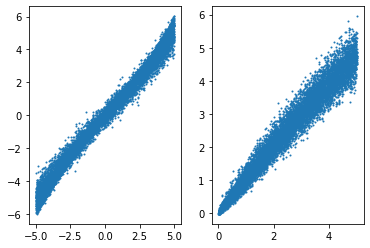

In [11]:
plt.subplot(121)
plt.scatter(theta[:10000, 0].numpy(), mle[:10000, 0].numpy(), s=1)

plt.subplot(122)
plt.scatter(theta[:10000, 1].numpy(), mle[:10000, 1].numpy(), s=1)


## initialize deepsets

In [24]:
# initialize the Fishnet model
deepset = Deepset(n_parameters=n_theta, 
                n_inputs=1, 
                n_hidden_score=[128,128,128], 
                activation_score=[tf.nn.elu, tf.nn.elu,  tf.nn.elu],
                n_hidden_fisher=[128,128,128], 
                activation_fisher=[tf.nn.elu, tf.nn.elu,  tf.nn.elu],
                activation_globals=[tf.nn.elu, tf.nn.elu, tf.nn.elu],
                n_hidden_globals=[128,128,128],
                optimizer=tf.keras.optimizers.Adam(lr=5e-4),
                theta_fid=theta_fid,
                priormu=tf.zeros(n_theta, dtype=tf.float32),
                priorCinv=tf.eye(n_theta, dtype=tf.float32))

/softs/python/py3mods/tensorflow/2.10.1/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [25]:
deepsets_history = deepset.train((data, theta, score_mask_deepsets, fisher_mask), lr=5e-4, epochs=30, lossfn='deepsets')
deepsets_history = deepset.train((data, theta, score_mask_deepsets, fisher_mask), lr=1e-4, epochs=30, lossfn='deepsets')

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:03<?, ?it/s, loss=3.86]

100%|██████████| 30/30 [01:06<00:00,  2.23s/it, loss=0.139]


## saliency plots

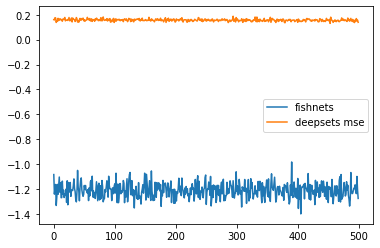

In [26]:
plt.plot(fishnets_history[100:], label='fishnets')
plt.plot(deepsets_history[100:], label='deepsets mse')
plt.legend()

In [27]:
# model MLEs
# score, _ = deepset.call(data)
# # sum the per-data point scores and Fishers, and include Gaussian prior correction
# score = tf.reduce_mean(score*score_mask, axis=1) # - tf.einsum('ij,j->i', self.priorCinv, (self.theta_fid - self.priormu))

# score = deepset.model_globals(score)
# prediction = score #tf.reduce_sum(score*score_mask, axis=1) #- tf.einsum('ij,j->i', deepset.priorCinv, (deepset.theta_fid - deepset.priormu))

prediction = deepset.compute_deepsets_pred_(data[:, :, :], score_mask_deepsets, fisher_mask)

100%|██████████| 50/50 [00:03<00:00, 12.52it/s]


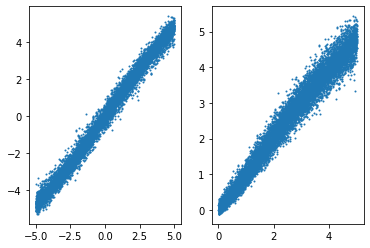

In [28]:
plt.subplot(121)
plt.scatter(theta[:10000, 0].numpy(), prediction[:10000, 0].numpy(), s=1)

plt.subplot(122)
plt.scatter(theta[:10000, 1].numpy(), prediction[:10000, 1].numpy(), s=1)

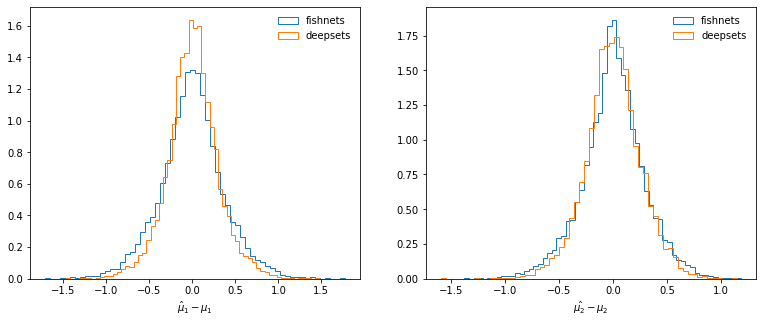

In [29]:
plt.figure(figsize=(13, 5))
plt.subplot(121)
plt.hist(mle[:10000,0].numpy() - theta[:10000,0].numpy(), bins = 60, histtype='step', density=True, label='fishnets')

plt.hist(prediction[:10000,0].numpy() - theta[:10000,0].numpy(), bins = 60, histtype='step', density=True, label='deepsets')
plt.xlabel(r'$\hat{\mu}_1 - \mu_1$')
plt.legend(frameon=False)


plt.subplot(122)
plt.hist(mle[:10000,1].numpy() - theta[:10000,1].numpy(), bins = 60, histtype='step', density=True, label='fishnets')
plt.hist(prediction[:10000,1].numpy() - theta[:10000,1].numpy(), bins = 60, histtype='step', density=True, label='deepsets')
plt.xlabel(r'$\hat{\mu_2} - \mu_2$')
plt.legend(frameon=False)

plt.show()

## now test the scaling

In [45]:
# data sizes
n_sims_test = 1000
n_data_test = 10000

n_theta = 2


# fiducial parameters
theta_fid = tf.constant([1.,2.0], dtype=tf.float32)
theta_fid_ = theta_fid.numpy()

# prior mean and covariance
priorCinv = tf.convert_to_tensor(np.eye(2), dtype=tf.float32)
priormu = tf.constant([0.,0.], dtype=tf.float32)

# get positions - THESE ARE THE THETA WE WANT
alpha = np.random.uniform(low=-5, high=5, size=(n_sims_test,))
beta = np.random.uniform(low=0, high=5, size=(n_sims_test,))

# get random angles at which flashes are generated from lighthouse
thetaD = np.random.uniform(-np.pi/2., np.pi/2., size=(n_sims_test, n_data_test))

# get the random distances (the data) at which the flashes are measured
x_k = (beta[..., np.newaxis] * np.tan(thetaD)) + alpha[..., np.newaxis]

sigma_noise = np.random.uniform(low=0.1, high=0.5, size=(n_sims_test, n_data_test))

# now stack all of the data and add some noise
data_test = np.random.normal(loc=x_k, scale=sigma_noise)[..., np.newaxis]

# make data neural-network friendly
datamax = 5.0
data_test /= datamax

# stack up parameters
theta_test = np.zeros((n_sims_test, 2))
theta_test[:, 0] = alpha
theta_test[:, 1] = beta

data_test.shape, theta_test.shape

((1000, 10000, 1), (1000, 2))

In [46]:
# stack up the data and parameters
data_test = tf.convert_to_tensor(np.arcsinh(data_test), dtype=tf.float32)
theta_test = tf.convert_to_tensor(theta_test[:, :n_theta], dtype=tf.float32)

# construct masks
score_mask_test = np.ones((n_sims_test, n_data_test, n_theta))
fisher_mask_test = np.ones((n_sims_test, n_data_test, n_theta, n_theta))

# for deepsets
score_mask_deepsets_test =  np.ones((n_sims_test, n_data_test, 5))


# mask or not?
masked = True

# make the masks
if masked is True:
    for i in range(n_sims_test):
        
        # how many points to mask?
        n_mask = np.random.randint(1, n_data_test-100)
        
        # choose which points to mask
        idx = np.random.choice(np.arange(n_data_test), n_mask, replace=False)
        
        # mask those points (set the fisher and score masks to zero for those points)
        for j in idx:
            score_mask_test[i,j,:] = 0
            fisher_mask_test[i,j,...] = 0
            score_mask_deepsets_test[i,j,:] = 0


score_mask_test = tf.convert_to_tensor(score_mask_test, dtype=tf.float32)
fisher_mask_test = tf.convert_to_tensor(fisher_mask_test, dtype=tf.float32)

score_mask_deepsets_test = tf.convert_to_tensor(score_mask_deepsets_test, dtype=tf.float32)

In [47]:
test_index = 1000

In [48]:
# fishnet MLEs
mle_test, F_test  = Model.compute_mle_(data_test[:test_index], score_mask_test[:test_index], fisher_mask_test[:test_index])

100%|██████████| 100/100 [00:11<00:00,  9.08it/s]


In [49]:
prediction_test = deepset.compute_deepsets_pred_(data_test[:test_index, :, :], score_mask_deepsets_test[:test_index], fisher_mask_test[:test_index])

100%|██████████| 100/100 [00:15<00:00,  6.50it/s]


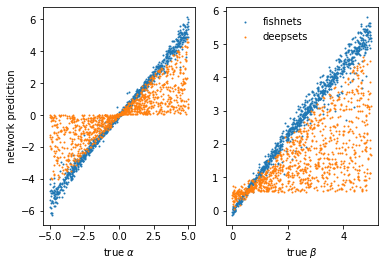

In [50]:
plt.subplot(121)
plt.scatter(theta_test[:test_index, 0].numpy(), mle_test[:test_index, 0].numpy(), s=1, label='fishnets')
plt.scatter(theta_test[:test_index, 0].numpy(), prediction_test[:test_index, 0].numpy(), s=1, label='deepsets')
plt.xlabel(r'true $\alpha$')
plt.ylabel('network prediction')


plt.subplot(122)
plt.scatter(theta_test[:test_index, 1].numpy(), mle_test[:test_index, 1].numpy(), s=1, label='fishnets')
plt.scatter(theta_test[:test_index, 1].numpy(), prediction_test[:test_index, 1].numpy(), s=1, label='deepsets')
plt.xlabel(r'true $\beta$')
#plt.ylabel('network prediction')
plt.legend(frameon=0.0)

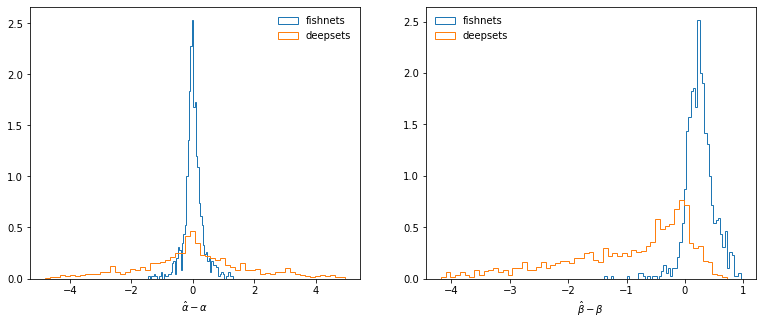

In [51]:
bins=60

plt.figure(figsize=(13, 5))
plt.subplot(121)
plt.hist(mle_test[:test_index,0].numpy() - theta_test[:test_index,0].numpy(), bins = bins, histtype='step', density=True, label='fishnets')

plt.hist(prediction_test[:test_index,0].numpy() - theta_test[:test_index,0].numpy(), bins = bins, histtype='step', density=True, label='deepsets')
plt.xlabel(r'$\hat{\alpha} - \alpha$')
plt.legend(frameon=False)


plt.subplot(122)
plt.hist(mle_test[:test_index,1].numpy() - theta_test[:test_index,1].numpy(), bins = bins, histtype='step', density=True, label='fishnets')
plt.hist(prediction_test[:test_index,1].numpy() - theta_test[:test_index,1].numpy(), bins = bins, histtype='step', density=True, label='deepsets')
plt.xlabel(r'$\hat{\beta} - \beta$')
plt.legend(frameon=False)

#plt.xlim(-10, 10)
plt.show()

In [182]:
# compute analytic posterior

priorAB = 1.0 #(1./5) * (1/ 10.)

def Prob(alp, beta, x, priorAB=priorAB):
	pro = priorAB
	lh = beta/(np.pi * ((x-alp)**2 + beta**2))
	pro = pro*lh
	return pro



In [303]:
from scipy.special import log_softmax

In [367]:
# compute the MLEs using a grid of alpha and beta values

# get positions - THESE ARE THE THETA WE WANT
# alpha = np.random.uniform(low=-5, high=5, size=(n_sims_test,))
# beta = np.random.uniform(low=0, high=5, size=(n_sims_test,))

afix = 1.0
bfix = 3.0

ndatfix = 159

# get random angles at which flashes are generated from lighthouse
thetafix = np.random.uniform(-np.pi/2., np.pi/2., size=(ndatfix,))

# get the random distances (the data) at which the flashes are measured
_x = bfix * np.tan(thetafix) + afix


_alphas = np.linspace(-5, 5, 20)
_betas = np.linspace(0.01, 5, 20)

x,y = np.meshgrid(_alphas, _betas)

probs = []

for _a,_b in zip(x.ravel(), y.ravel()):
    _p = Prob(_a, _b, x=_x)
   # _p = np.prod(_p / np.sum(_p))
    probs.append(np.sum(np.log(_p)))

probs = np.array(probs)

In [378]:
np.argmax(np.exp(probs - np.max(probs)).reshape(20,20), axis=0), np.argmax(np.exp(probs - np.max(probs)).reshape(20,20), axis=1)

(array([19, 19, 19, 19, 18, 16, 15, 13, 12, 11, 10, 10, 10, 10, 11, 12, 14,
        15, 17, 19]),
 array([10, 11, 11, 11, 12, 12, 12, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11]))

In [374]:
x.flatten()[211]

0.7894736842105257

In [375]:
y.flatten()[211]

2.6363157894736844

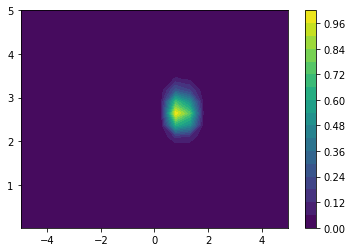

In [371]:
plt.contourf(x, y, np.exp(probs - np.max(probs)).reshape(20,20), levels=17)
plt.colorbar()

In [152]:
x,y = np.meshgrid(oms[::1], s8s[::1])


mf2 = MassFunction(Mmin=10,
                  Mmax=16,
                  hmf_model="PS")

dndms2 = []
fsigmas2 = []
int_fsigmas_end2 = []
int_dndms2 = []
int_dndms_end2 = []

for _oms,_s8s in zip(x.ravel(), y.ravel()):
    mf2.update(z=0, cosmo_params={"Om0":_oms}, sigma_8=_s8s)
    dndms2.append(mf2.dndm[masscut_index])
    fsigmas2.append(mf2.fsigma[masscut_index])
    int_dndms2.append(np.sum(mf2.dndm[:masscut_index])) 
    int_dndms_end2.append(np.sum(mf2.dndm[masscut_index:]))     # integration from M_cut
    int_fsigmas_end2.append(np.sum(mf2.fsigma[masscut_index:])) # integration from M_cut

NameError: name 'oms' is not defined